<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day%203%23_Dummy_Telecom_case_study_Model_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Upload raw data file from your local file system

from google.colab import files

files.upload()

In [0]:
# Read the file into a data frame

import pandas as pd
data = pd.read_csv("RawdatafileV0.0.csv")
data.head()

,Cust_id,Plan_Chg_Flag,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27
0,1000,Yes,North,Medium,Private,30,Male,0,200,7,Cash,Postpaid,1,1,300,300,300,300,10,50,500,2,1,300,300,100,50,20,Good
1,1001,Yes,Central,Low,Private,30,Female,3,200,15,Cash,Postpaid,1,1,300,300,600,300,10,50,1500,1,1,300,300,20,500,20,Poor
2,1002,Yes,Central,High,Private,50,Male,0,600,7,Card,Postpaid,2,1,600,300,600,300,10,50,1500,2,1,600,300,100,500,20,Poor
3,1003,Yes,South,High,Private,20,Male,3,600,7,Card,Postpaid,2,1,600,300,300,100,10,200,1500,1,1,300,600,100,500,20,Poor
4,1004,Yes,North,High,Private,20,Female,3,600,15,Card,Postpaid,2,1,600,600,300,300,10,50,500,2,2,600,600,100,500,20,Poor


In [0]:
data.fillna('UNK', inplace = True) # Replace nulls with a placeholder

In [0]:
## There are 90 rows which are duplicates, dropping them 
selCols = data.columns

data.drop_duplicates(subset = selCols[2:], inplace= True)
print(data.shape)

# Copying out the index variable & the target variable
custID = data['Cust_id']
target = data['Plan_Chg_Flag']

# Drop Var10 since it has the same value (POSTPAID)
# Removing the target variable & index variable (cust_id)

data.drop(labels=['Cust_id', 'Plan_Chg_Flag', 'Var10'], inplace = True, axis =1) # Var10 is a constant (POSTPAID)

# Copying all column names 
# Converting all columns to categories 

selCols = data.columns # Read the column names

data = data.apply(lambda x: x.astype('category')) # Convert all columns to category 

(4910, 29)


In [0]:
# Convert to one-hot-encoding 
df_with_dummies = pd.get_dummies( data, columns = selCols)
df_with_dummies['Cust_id'] = custID

print(df_with_dummies.shape)
df_with_dummies.head()

(4910, 63)


,Var1_Central,Var1_North,Var1_South,Var1_UNK,Var2_High,Var2_Low,Var2_Medium,Var3_Govt,Var3_Private,Var3_Unemployed,Var4_20,Var4_24,Var4_30,Var4_50,Var4_99,Var4_120,Var5_Female,Var5_Male,Var6_0,Var6_3,Var7_200,Var7_600,Var7_1200,Var8_7,Var8_15,Var9_Card,Var9_Cash,Var11_1,Var11_2,Var12_1,Var12_2,Var13_300,Var13_600,Var14_300,Var14_600,Var15_300,Var15_600,Var16_100,Var16_300,Var17_10,Var17_300,Var18_50,Var18_200,Var19_500,Var19_1500,Var20_1,Var20_2,Var21_1,Var21_2,Var22_300,Var22_600,Var23_300,Var23_600,Var24_20,Var24_100,Var25_50,Var25_500,Var26_20,Var26_50,Var27_Good,Var27_Poor,Var27_UNK,Cust_id
0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1000
1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,0,1001
2,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1002
3,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1003
4,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1004


In [0]:
# Importing the sklearn libraries
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

# Converting the target variable via LabelEncoding
label_encoder = LabelEncoder().fit(target)
targetLE = label_encoder.transform(target)

In [0]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(df_with_dummies, targetLE, test_size=0.3, shuffle=True, stratify=target, random_state= 93456)

In [0]:
# Removing the cust_id before creating the model
custID_train = train_x['Cust_id']
custID_valid = valid_x['Cust_id']

train_x.drop(labels= ['Cust_id'], axis= 1, inplace= True)
valid_x.drop(labels= ['Cust_id'], axis= 1, inplace= True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
#------------------------Build LightGBM Model-----------------------
import lightgbm as lgb

train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

#Select Hyper-Parameters
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 13,
          'max_depth' : -1,
          'n_estimators' : 200,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : -1,
          'num_threads' : 4
}


#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 30,
                 verbose_eval= 10
                 )

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's auc: 0.962818
[20]	valid_0's auc: 0.992743
[30]	valid_0's auc: 0.995345
[40]	valid_0's auc: 0.997338
[50]	valid_0's auc: 0.998597
[60]	valid_0's auc: 0.998699
[70]	valid_0's auc: 0.998753
[80]	valid_0's auc: 0.998735
[90]	valid_0's auc: 0.998591
[100]	valid_0's auc: 0.998248
[110]	valid_0's auc: 0.998254
Early stopping, best iteration is:
[86]	valid_0's auc: 0.998771


In [0]:
!pip install shap

     |████████████████████████████████| 235kB 5.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


In [0]:
import shap

In [0]:
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(valid_x)

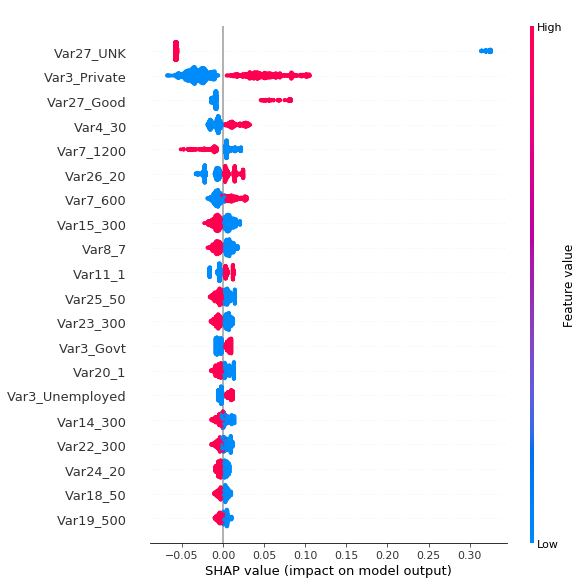

In [0]:
# Plot summary_plot
shap.summary_plot(shap_values, valid_x)

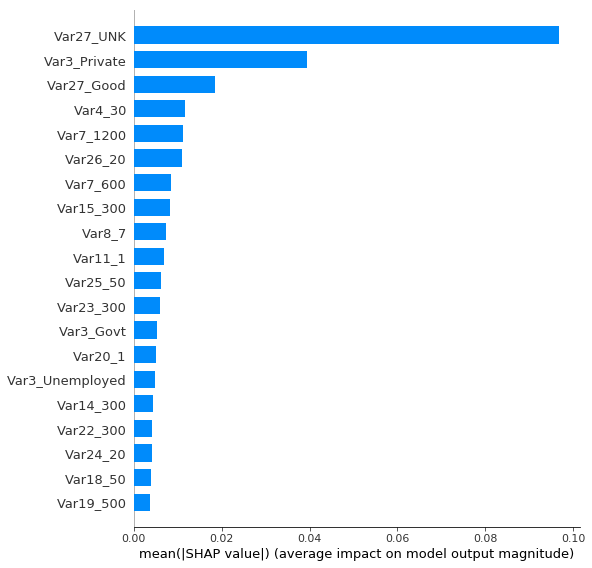

In [0]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, valid_x, plot_type='bar')

In [0]:
# Low values of Var27 has a high impact on the prediction values. When Var27_UNK =0, it is either a GOOD ore POOR value.   
# For Plan_chg_flag = 1 customers have either a Var27 (Good/Poor) value 

valid_x.Var27_UNK.value_counts() 

1    1252
0     221
Name: Var27_UNK, dtype: int64

In [0]:
# load JS visualization code to notebook
shap.initjs()

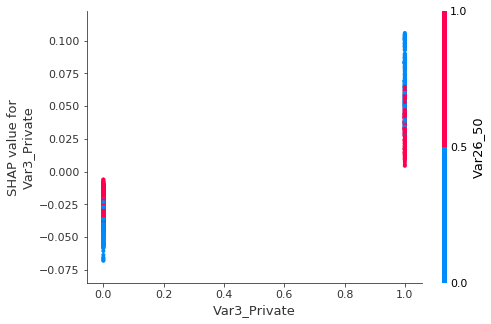

In [0]:
# When customer is employed in a Private organization, lower values of Var26_50 have a larger impact on the prediction 
# Var3_Private = 1
# Var26_50 = 0

shap.dependence_plot("Var3_Private", shap_values, valid_x)

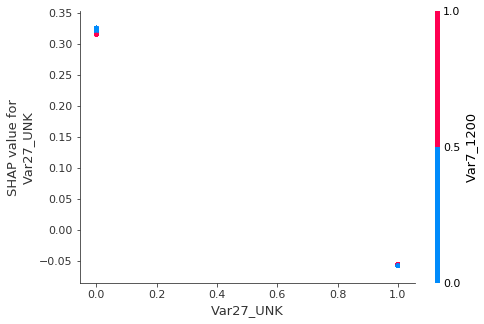

In [0]:
# Var27_UNK = 0

shap.dependence_plot("Var27_UNK", shap_values, valid_x)

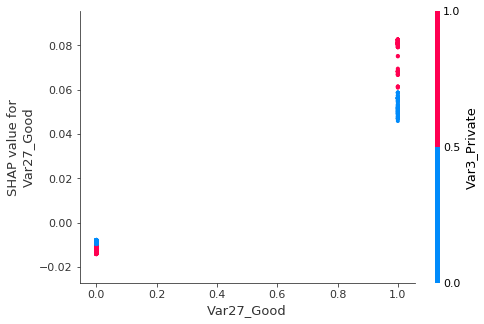

In [0]:
# Have a large impact onthe prediction (Plan_Chg_Flag = 1)
# Var27_Good = 1 
# Var3_Private = 1

shap.dependence_plot("Var27_Good", shap_values, valid_x)

In [0]:
# calculating the interaction values 

shap_interaction_values = shap.TreeExplainer(lgbm).shap_interaction_values(valid_x)

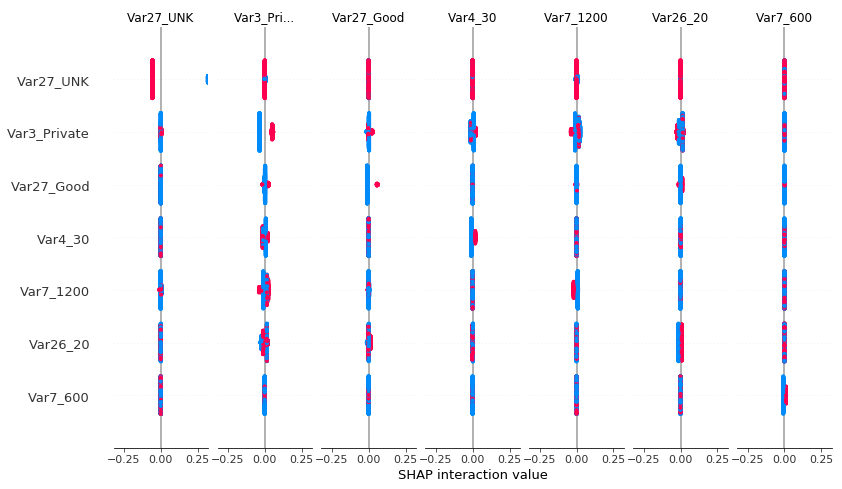

In [0]:
shap.summary_plot(shap_interaction_values, valid_x)

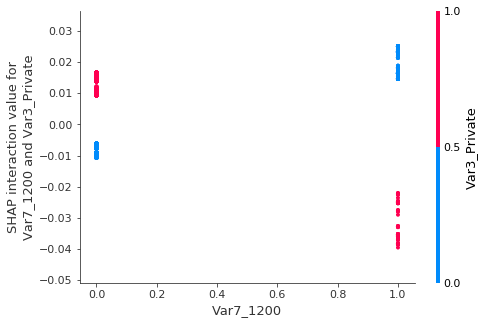

In [0]:
# Interaction between Var7_1200 and Var3_Private is not conclusive
# When VAr7_1200 =0 , and Var3_Private = 1 , has a higher impact on the shap values & vice versa
# When Var7_1200 =1, Var3_Private = 1 has a negative impact & vice versa

shap.dependence_plot(("Var7_1200", "Var3_Private"), shap_interaction_values, valid_x)

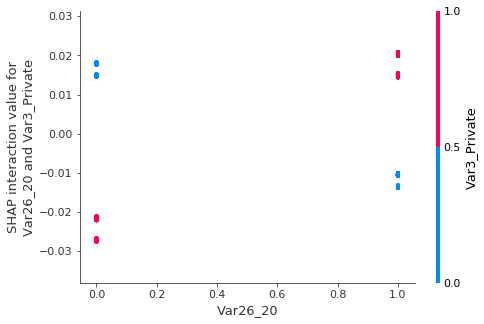

In [0]:
# Var26_20 =1 & Var3_Private =1 has a positive impact

shap.dependence_plot(("Var26_20", "Var3_Private"), shap_interaction_values, valid_x)

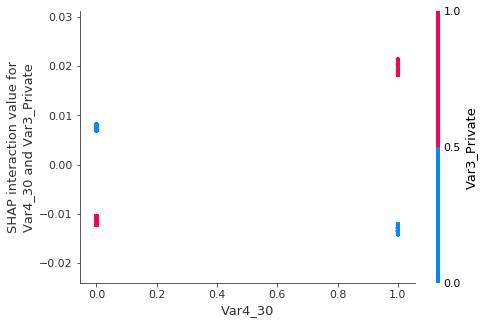

In [0]:

shap.dependence_plot(("Var4_30", "Var3_Private"), shap_interaction_values, valid_x)

In [0]:
import numpy as np 

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([valid_x.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
61,Var27_UNK,0.0967409
8,Var3_Private,0.0394421
59,Var27_Good,0.0185841
12,Var4_30,0.0117184
22,Var7_1200,0.0112631
57,Var26_20,0.0108891
21,Var7_600,0.00849816
35,Var15_300,0.00816376
23,Var8_7,0.00726484
27,Var11_1,0.00679464
